### gQuant Tutorial
First import all the necessary modules.

In [1]:
import sys; sys.path.insert(0, '..')
import os
import warnings
import ipywidgets as widgets
from gquant.dataframe_flow import TaskGraph

warnings.simplefilter("ignore")

In this tutorial, we are going to use gQuant to do a simple quant job. The task is fully described in a yaml file

In [2]:
!head -n 31 ../taskgraphs/simple_trade.gq.yaml

- id: stock_data
  type: CsvStockLoader
  conf:
    file: /home/quant/gQuant/notebooks/data/stock_price_hist.csv.gz
  inputs: {}
- id: stock_name
  type: StockNameLoader
  conf:
    file: /home/quant/gQuant/notebooks/data/security_master.csv.gz
  inputs: {}
- id: stock_selector
  type: AssetFilterNode
  conf:
    asset: 4330
  inputs:
    name_map: stock_name.map_data
    stock_in: stock_data.cudf_out
- id: ""
  type: Output_Collector
  conf: {}
  inputs:
    in1: stock_selector.stock_name
    in2: lineplot.lineplot
    in3: barplot.barplot
    in4: sharpe_ratio.sharpe_out
    in5: cumulative_return.cum_return
    in6: stock_data.cudf_out
- id: sort_node
  type: SortNode
  conf:
    keys:


The yaml file is describing the computation task by a graph, we can visualize it

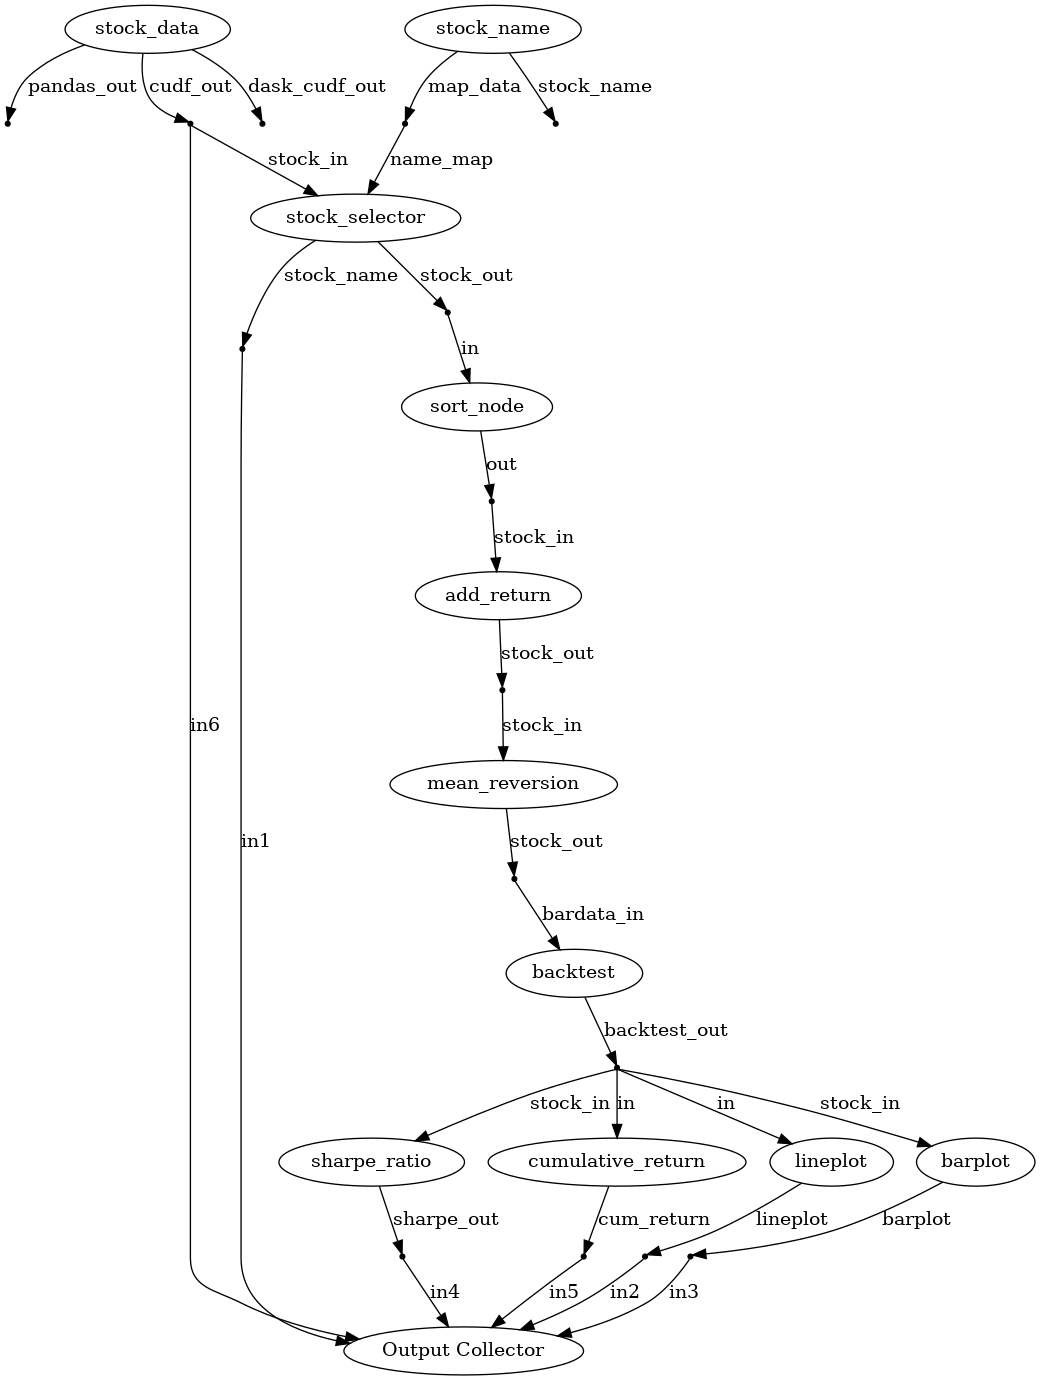

In [3]:
task_graph = TaskGraph.load_taskgraph('../taskgraphs/simple_trade.gq.yaml')
task_graph.draw(show='ipynb', show_ports=True)

In [4]:
task_graph.draw()

GQuantWidget(sub=HBox(), value=[OrderedDict([('id', 'stock_data'), ('type', 'CsvStockLoader'), ('conf', {'file…

In [5]:
task_graph.run(formated=True)

We define a method to organize the output images

In [6]:
def plot_figures(result):
    # format the figures
    figure_width = '1200px'
    figure_height = '400px'
    bar_figure = result['barplot.barplot']
    sharpe_number = result['sharpe_ratio.sharpe_out']
    cum_return = result['cumulative_return.cum_return']
    signals = result['lineplot.lineplot']
    symbol = result['stock_selector.stock_name']

    bar_figure.layout.height = figure_height
    bar_figure.layout.width = figure_width
    cum_return.layout.height = figure_height
    cum_return.layout.width = figure_width
    cum_return.title = 'P & L %.3f' % (sharpe_number)
    bar_figure.marks[0].labels = [symbol]
    cum_return.marks[0].labels = [symbol]
    signals.layout.height = figure_height
    signals.layout.width = figure_width
    bar_figure.axes = [bar_figure.axes[1]]
    cum_return.axes = [cum_return.axes[0]]
    output = widgets.VBox([bar_figure, cum_return, signals])

    return output

Rerun the graph and send the computation result to the `plot_figure` method

In [7]:
result = task_graph.run()
plot_figures(result)

You can change the TaskGraph node parameters interatively and hit the run button to get the updated result. It can also be done programtically, E.g. change the mean reversion parameters:

In [8]:
o = task_graph.run(
            outputs=(list(result.get_keys())[0:]),
            replace={'stock_data': {"load": {'cudf_out': result['stock_data.cudf_out']}},
                     'mean_reversion': {'conf': {'fast': 1, 'slow': 10}}})
figure_combo = plot_figures(o)
figure_combo

Since computation is accelerated in the GPU, we can do hyper-parameter search interatively, try to change the parameters of the `slow` and `fast` for the moving average and see if you can improve the result:

In [9]:
para_selector = widgets.IntRangeSlider(value=[10, 30],
                                       min=3,
                                       max=60,
                                       step=1,
                                       description="MA:",
                                       disabled=False,
                                       continuous_update=False,
                                       orientation='horizontal',
                                       readout=True)


def para_selection(*stocks):
    with out:
        print('run')
        para1 = para_selector.value[0]
        para2 = para_selector.value[1]
        o = task_graph.run(
            outputs=(list(result.get_keys())[0:]),
            replace={'stock_data': {"load": {'cudf_out': result['stock_data.cudf_out']}},
                     'mean_reversion': {'conf': {'fast': para1, 'slow': para2}}})
        figure_combo = plot_figures(o)
        if (len(w.children) < 2):
            w.children = (w.children[0], figure_combo,)
        else:
            w.children[1].children[1].marks = figure_combo.children[1].marks
            w.children[1].children[2].marks = figure_combo.children[2].marks
            w.children[1].children[1].title = 'P & L %.3f' % (o['sharpe_ratio.sharpe_out'])


out = widgets.Output(layout={'border': '1px solid black'})
para_selector.observe(para_selection, 'value')
selectors = widgets.HBox([para_selector])
w = widgets.VBox([selectors])
w